# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_loader import LoadImage
from image_preprocesser import preprocess_image, apply_preprocessing
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix, plot_auc_curve
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2024-12-03 13:05:19.552068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733227519.567699   19693 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733227519.572357   19693 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:05:19.588413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [3]:
#Import images
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.


I0000 00:00:1733227525.033194   19693 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [4]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(256, 256)
)

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

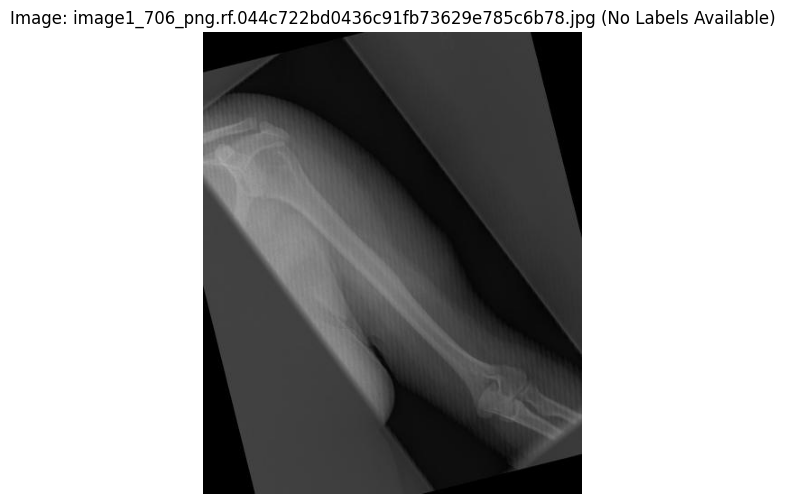

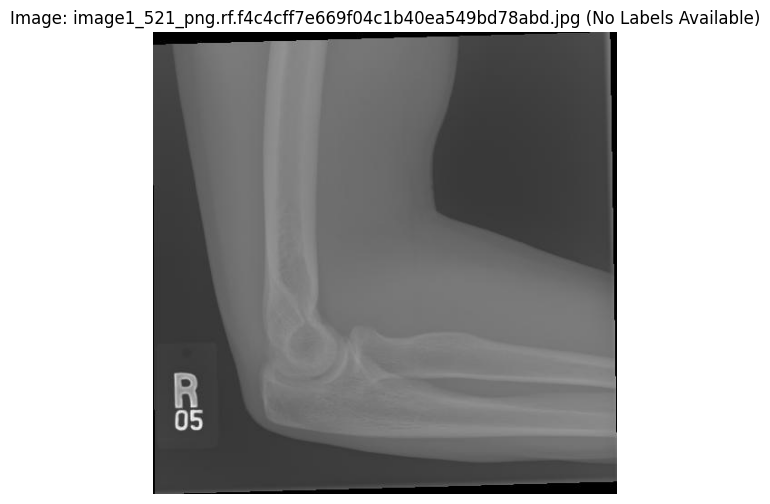

In [10]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### **Contruct a CNN**

### *Model 1*

In [5]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

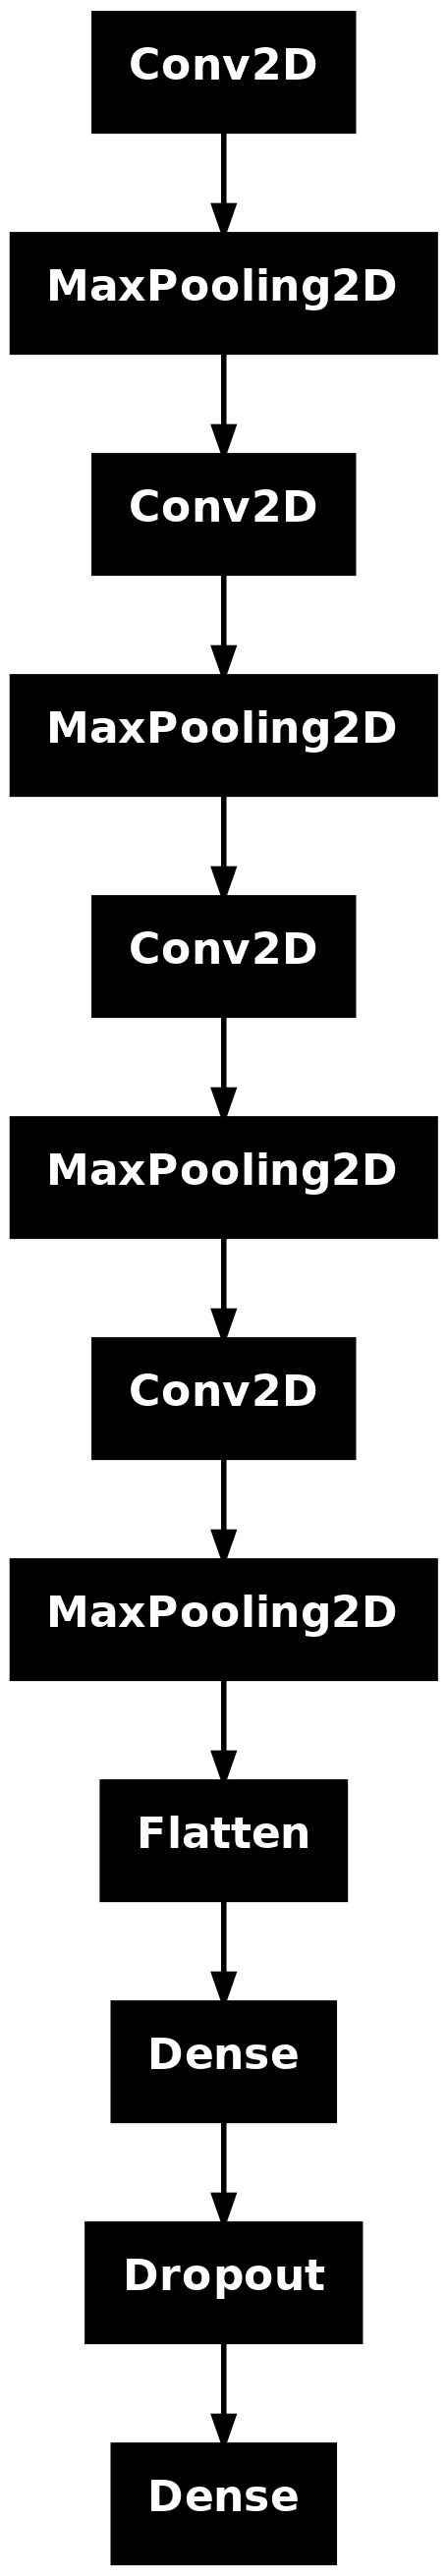

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [7]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [8]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback()

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback()

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1733227544.084226   21265 service.cc:148] XLA service 0x7f99b000cf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733227544.084268   21265 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-03 13:05:44.135309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733227544.319325   21265 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-03 13:05:44.702670: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4750 - loss: 0.6949 

I0000 00:00:1733227548.239904   21265 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5788 - loss: 0.6810

2024-12-03 13:05:55.105025: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-03 13:05:55.157296: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5790 - loss: 0.6809 - val_accuracy: 0.4959 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5857 - loss: 0.6786

2024-12-03 13:05:57.772013: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-03 13:05:57.772055: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-03 13:05:57.772071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:05:57.772083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trace

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6334 - loss: 0.6598 - val_accuracy: 0.4959 - val_loss: 0.7128 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5931 - loss: 0.6791 - val_accuracy: 0.4959 - val_loss: 0.7093 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6651 - loss: 0.6463

2024-12-03 13:06:06.053978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-03 13:06:06.054004: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:06:06.054018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6167 - loss: 0.6695 - val_accuracy: 0.4959 - val_loss: 0.7322 - learning_rate: 0.0010


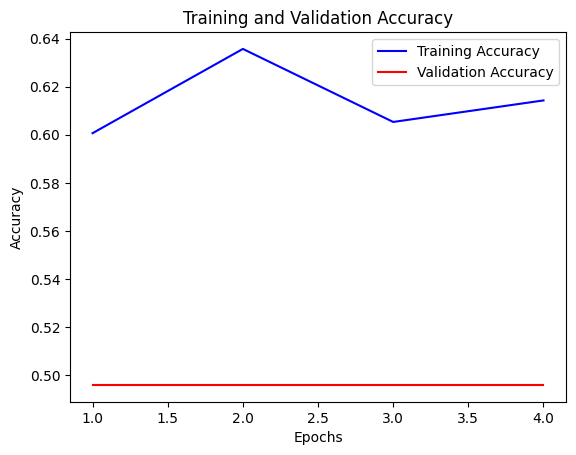

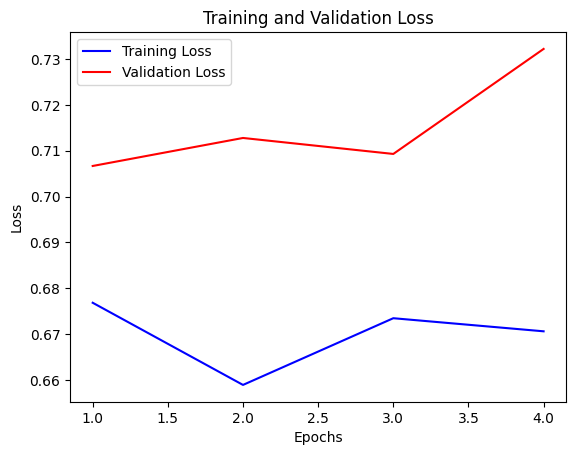

In [9]:
plot_training_history(history)

------

In [12]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_CNN1, train_ds, epochs = 100, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5959 - loss: 0.6757 - val_accuracy: 0.4959 - val_loss: 0.7185 - learning_rate: 5.0000e-04
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6023 - loss: 0.6715

2024-12-03 13:07:55.396496: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-03 13:07:55.396529: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:07:55.396546: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6001 - loss: 0.6750 - val_accuracy: 0.4959 - val_loss: 0.7198 - learning_rate: 5.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5899 - loss: 0.6779 - val_accuracy: 0.4959 - val_loss: 0.7174 - learning_rate: 5.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6377 - loss: 0.6575 - val_accuracy: 0.4959 - val_loss: 0.7369 - learning_rate: 5.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5909 - loss: 0.6775 - val_accuracy: 0.4959 - val_loss: 0.7116 - learning_rate: 5.0000e-04
Epoch 6/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6568 - loss: 0.6492

2024-12-03 13:08:11.822648: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:11.822678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6366 - loss: 0.6569 - val_accuracy: 0.4959 - val_loss: 0.7154 - learning_rate: 5.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5957 - loss: 0.6738 - val_accuracy: 0.4959 - val_loss: 0.7149 - learning_rate: 5.0000e-04
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5361 - loss: 0.6961

2024-12-03 13:08:20.050223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:20.050252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6231 - loss: 0.6587 - val_accuracy: 0.4959 - val_loss: 0.7181 - learning_rate: 5.0000e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5965 - loss: 0.6716 - val_accuracy: 0.4959 - val_loss: 0.7101 - learning_rate: 5.0000e-04
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5750 - loss: 0.6820

2024-12-03 13:08:28.262422: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-03 13:08:28.262446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:28.262458: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6125 - loss: 0.6607 - val_accuracy: 0.4959 - val_loss: 0.7136 - learning_rate: 5.0000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5935 - loss: 0.6753 - val_accuracy: 0.4959 - val_loss: 0.7085 - learning_rate: 5.0000e-04
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5968 - loss: 0.6753

2024-12-03 13:08:36.567589: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:36.567618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6273 - loss: 0.6655 - val_accuracy: 0.4959 - val_loss: 0.7098 - learning_rate: 5.0000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5904 - loss: 0.6739 - val_accuracy: 0.4959 - val_loss: 0.7075 - learning_rate: 5.0000e-04
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6840 - loss: 0.6243

2024-12-03 13:08:44.919583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:44.919621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6448 - loss: 0.6494 - val_accuracy: 0.4959 - val_loss: 0.7124 - learning_rate: 5.0000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5943 - loss: 0.6673 - val_accuracy: 0.4959 - val_loss: 0.7095 - learning_rate: 5.0000e-04
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5096 - loss: 0.6923

2024-12-03 13:08:53.231061: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:08:53.231096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5685 - loss: 0.6766 - val_accuracy: 0.4959 - val_loss: 0.7109 - learning_rate: 5.0000e-04
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5934 - loss: 0.6742 - val_accuracy: 0.4959 - val_loss: 0.7109 - learning_rate: 5.0000e-04
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6699 - loss: 0.6394

2024-12-03 13:09:01.475988: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:01.476028: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6373 - loss: 0.6552 - val_accuracy: 0.4959 - val_loss: 0.7127 - learning_rate: 5.0000e-04
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5892 - loss: 0.6744 - val_accuracy: 0.4959 - val_loss: 0.7055 - learning_rate: 5.0000e-04
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5982 - loss: 0.6766

2024-12-03 13:09:09.737420: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:09.737454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6067 - loss: 0.6694 - val_accuracy: 0.4959 - val_loss: 0.7067 - learning_rate: 5.0000e-04
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5948 - loss: 0.6736 - val_accuracy: 0.4959 - val_loss: 0.7059 - learning_rate: 5.0000e-04
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6852 - loss: 0.6430

2024-12-03 13:09:17.864612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:17.864645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6516 - loss: 0.6530 - val_accuracy: 0.4959 - val_loss: 0.7099 - learning_rate: 5.0000e-04
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5918 - loss: 0.6732 - val_accuracy: 0.4959 - val_loss: 0.7069 - learning_rate: 5.0000e-04
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6080 - loss: 0.6552

2024-12-03 13:09:26.131487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:26.131522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6344 - loss: 0.6493 - val_accuracy: 0.4959 - val_loss: 0.7085 - learning_rate: 5.0000e-04
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5895 - loss: 0.6775 - val_accuracy: 0.4959 - val_loss: 0.7110 - learning_rate: 5.0000e-04
Epoch 26/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5913 - loss: 0.6741

2024-12-03 13:09:34.294634: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-03 13:09:34.294666: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:34.294680: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6064 - loss: 0.6665 - val_accuracy: 0.4959 - val_loss: 0.7108 - learning_rate: 5.0000e-04
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5901 - loss: 0.6727 - val_accuracy: 0.4959 - val_loss: 0.7099 - learning_rate: 5.0000e-04
Epoch 28/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6378 - loss: 0.6534

2024-12-03 13:09:42.496398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:09:42.496430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6290 - loss: 0.6575 - val_accuracy: 0.4959 - val_loss: 0.7105 - learning_rate: 5.0000e-04
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5961 - loss: 0.6719 - val_accuracy: 0.4959 - val_loss: 0.7132 - learning_rate: 5.0000e-04


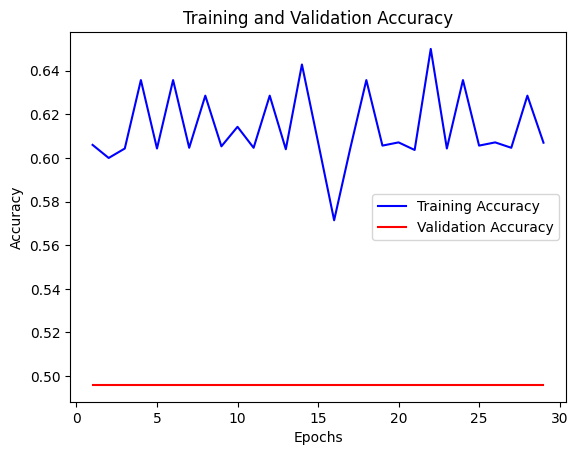

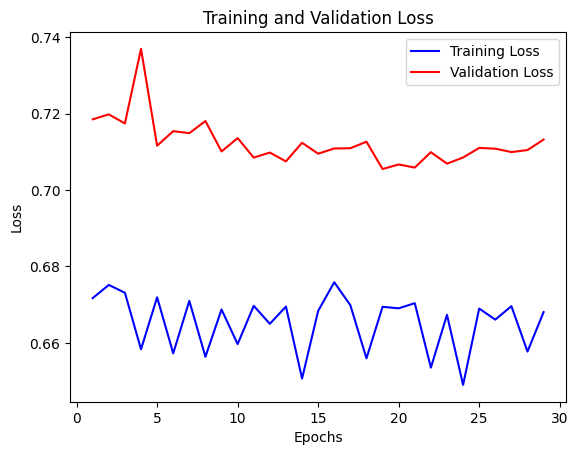

In [13]:
plot_training_history(history)

----

In [14]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [15]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5946 - loss: 0.6700 - val_accuracy: 0.4959 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5971 - loss: 0.6768

2024-12-03 13:11:03.390932: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:11:03.390972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6203 - loss: 0.6840 - val_accuracy: 0.4959 - val_loss: 0.7097 - learning_rate: 1.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5954 - loss: 0.6688 - val_accuracy: 0.4959 - val_loss: 0.7113 - learning_rate: 1.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6227 - loss: 0.6624 - val_accuracy: 0.4959 - val_loss: 0.7116 - learning_rate: 1.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5913 - loss: 0.6741 - val_accuracy: 0.4959 - val_loss: 0.7102 - learning_rate: 1.0000e-04
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6771 - loss: 0.6348

2024-12-03 13:11:19.681179: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:11:19.681217: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6785 - loss: 0.6343 - val_accuracy: 0.4959 - val_loss: 0.7106 - learning_rate: 1.0000e-04


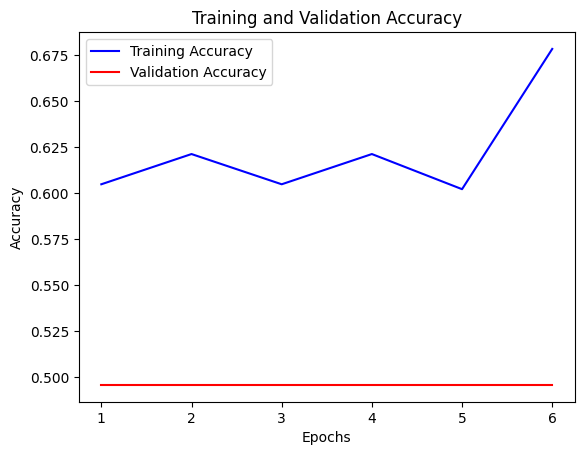

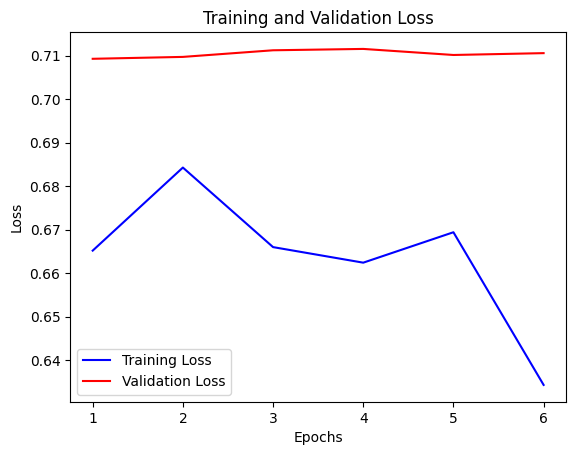

In [16]:
plot_training_history(history)

------------

### *Model 2*

In [17]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

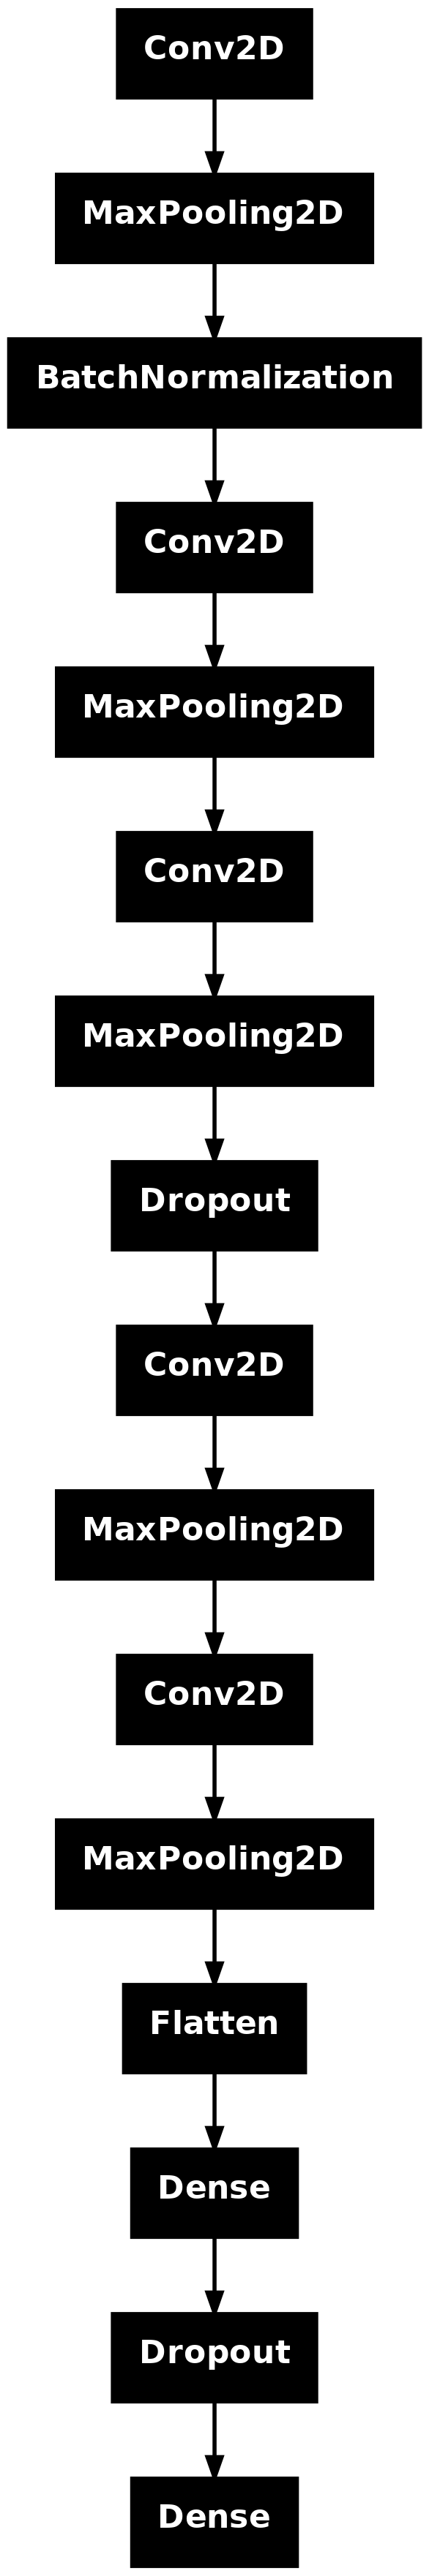

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [18]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = model_CNN2.fit(
    train_ds,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_ds,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100


2024-12-03 13:20:44.669498: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5617 - loss: 0.7274

2024-12-03 13:20:53.686168: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-03 13:20:54.426357: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5619 - loss: 0.7272 - val_accuracy: 0.4959 - val_loss: 0.7065 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6560 - loss: 0.6551 - val_accuracy: 0.4959 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5923 - loss: 0.6757 - val_accuracy: 0.4959 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5818 - loss: 0.7112 - val_accuracy: 0.4959 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5903 - loss: 0.6767 - val_accuracy: 0.4959 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5878 - loss: 0.6818

2024-12-03 13:21:11.729089: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:21:11.729130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6062 - loss: 0.6737 - val_accuracy: 0.4959 - val_loss: 0.7153 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5887 - loss: 0.6802 - val_accuracy: 0.4959 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 8/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6110 - loss: 0.6663

2024-12-03 13:21:20.021285: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:21:20.021329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6416 - loss: 0.6553 - val_accuracy: 0.4959 - val_loss: 0.7146 - learning_rate: 0.0010


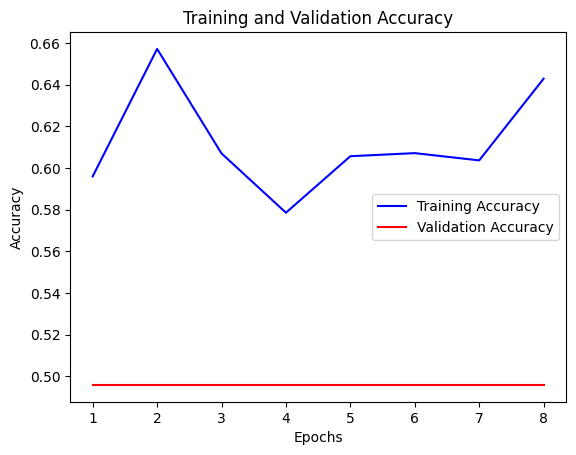

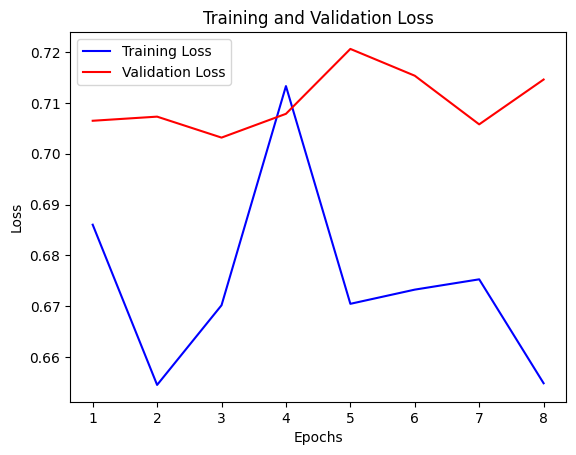

In [20]:
plot_training_history(history)

---------

### *Model 3*

In [21]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

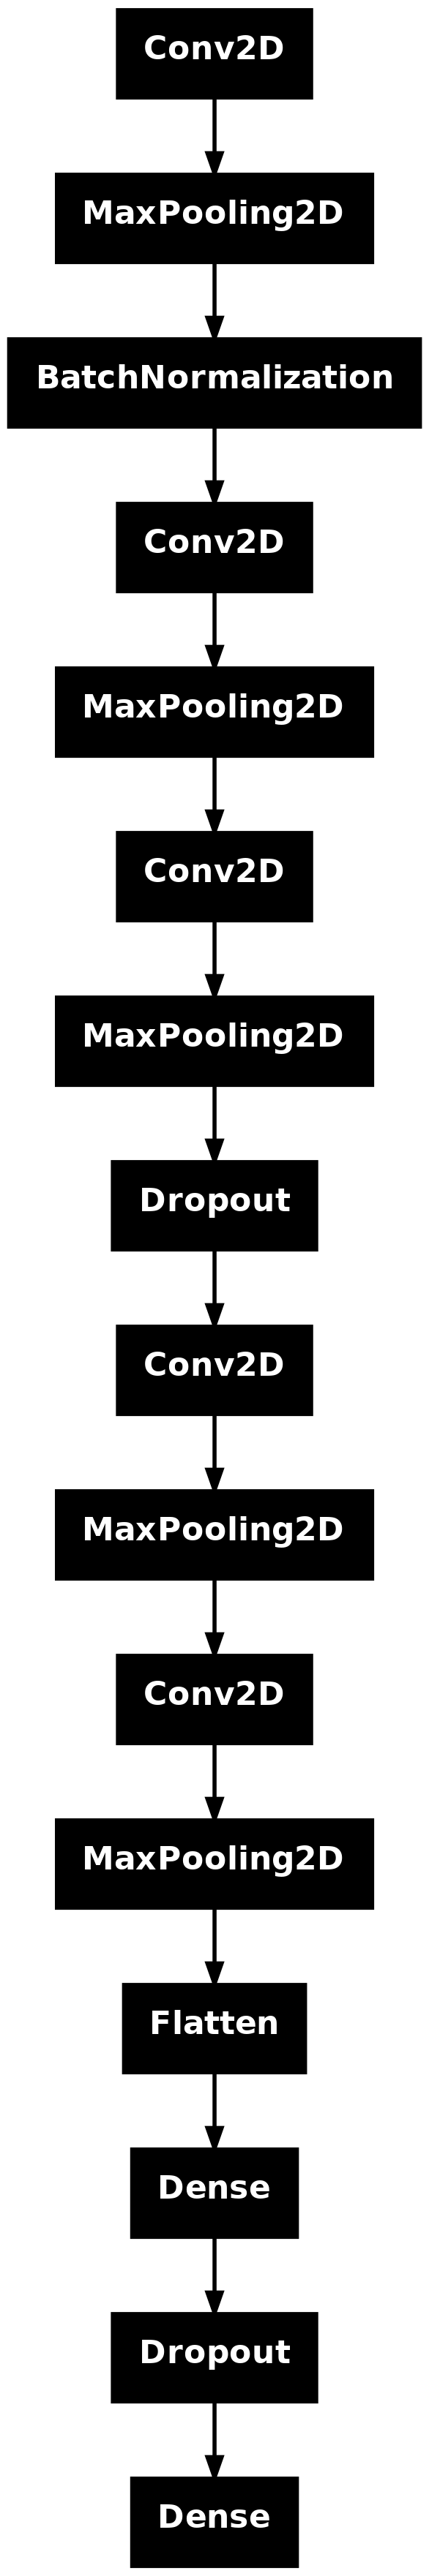

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [22]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN3, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5890 - loss: 5.5248 - val_accuracy: 0.4959 - val_loss: 0.8587 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6816 - loss: 0.7915

2024-12-03 13:24:35.228228: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:24:35.228262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6310 - loss: 0.8079 - val_accuracy: 0.4959 - val_loss: 0.8674 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5862 - loss: 0.7723 - val_accuracy: 0.4959 - val_loss: 0.7550 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5835 - loss: 0.7115

2024-12-03 13:24:43.430524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:24:43.430557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5788 - loss: 0.7131 - val_accuracy: 0.4959 - val_loss: 0.7474 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5920 - loss: 0.6974 - val_accuracy: 0.4959 - val_loss: 0.7216 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7244 - loss: 0.6304

2024-12-03 13:24:51.791637: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:24:51.791664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6739 - loss: 0.6513 - val_accuracy: 0.4959 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5896 - loss: 0.6848 - val_accuracy: 0.4959 - val_loss: 0.7205 - learning_rate: 0.0010
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6773 - loss: 0.6442

2024-12-03 13:25:00.093859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:25:00.093900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6513 - loss: 0.6534 - val_accuracy: 0.4959 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5950 - loss: 0.6772 - val_accuracy: 0.4959 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6308 - loss: 0.6606

2024-12-03 13:25:08.491238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:25:08.491269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6423 - loss: 0.6568 - val_accuracy: 0.4959 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5892 - loss: 0.6781 - val_accuracy: 0.4959 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5354 - loss: 0.6987

2024-12-03 13:25:16.832147: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:25:16.832180: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5768 - loss: 0.6827 - val_accuracy: 0.4959 - val_loss: 0.7194 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5859 - loss: 0.6802 - val_accuracy: 0.4959 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6345 - loss: 0.6595

2024-12-03 13:25:25.128774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:25:25.128810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6084 - loss: 0.6708 - val_accuracy: 0.4959 - val_loss: 0.7192 - learning_rate: 0.0010


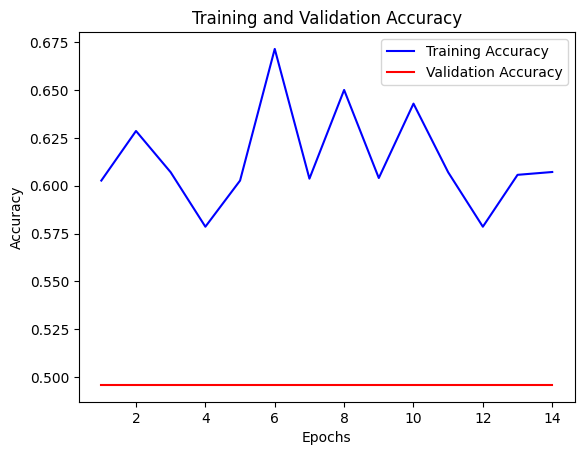

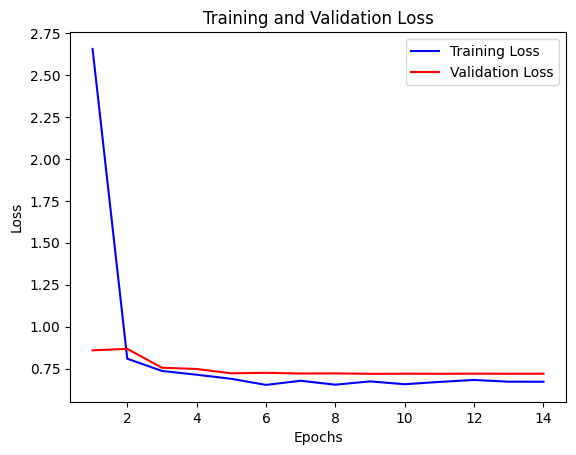

In [24]:
plot_training_history(history)

------------

### **Pretrained network VGG16**

In [25]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

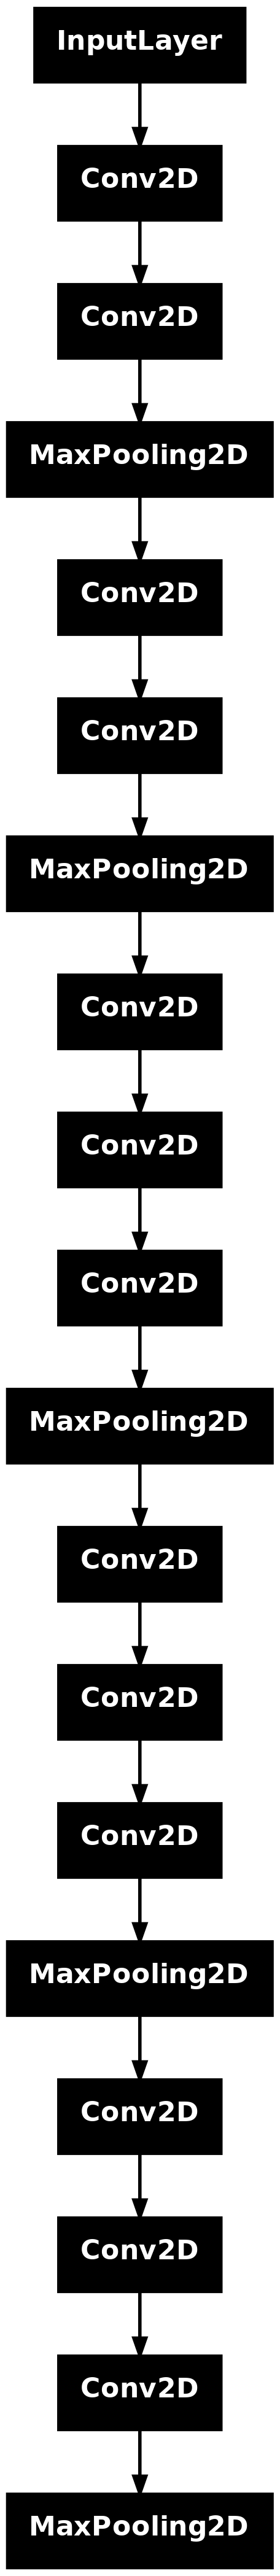

In [19]:
tf.keras.utils.plot_model(conv_base_VGG16)

### *Loading and preprocessing images*

In [28]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [29]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### *Fine-tunning*

**Model 1**

In [30]:
model_VGG16_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # Full-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

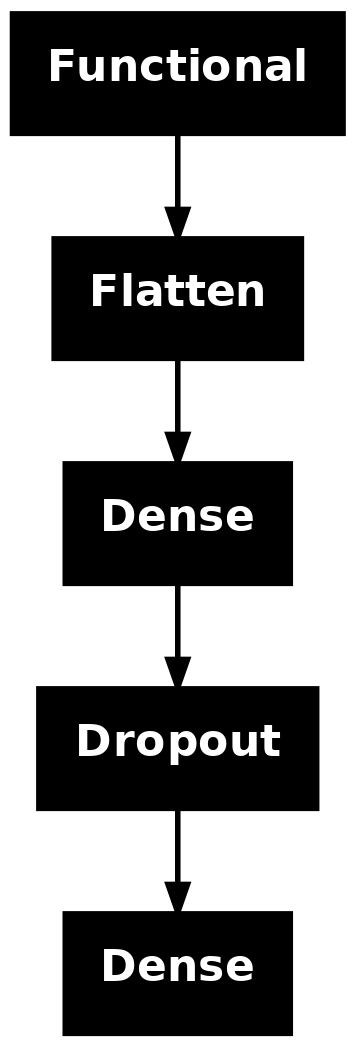

In [6]:
tf.keras.utils.plot_model(model_VGG16_1)

In [31]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_VGG16_1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-03 13:31:27.225697: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-03 13:31:27.462956: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5667 - loss: 1.0755

2024-12-03 13:31:55.427227: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-03 13:31:55.494866: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - accuracy: 0.5669 - loss: 1.0737 - val_accuracy: 0.4959 - val_loss: 0.7020 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.5857 - loss: 0.6754

2024-12-03 13:32:01.220768: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6334 - loss: 0.6696 - val_accuracy: 0.4959 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5922 - loss: 0.6875 - val_accuracy: 0.4959 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6167 - loss: 0.6738 - val_accuracy: 0.4959 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5976 - loss: 0.6819 - val_accuracy: 0.4959 - val_loss: 0.7094 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.6023 - loss: 0.6803

2024-12-03 13:32:52.138290: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:32:52.138384: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6001 - loss: 0.6796 - val_accuracy: 0.4959 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.5881 - loss: 0.6811 - val_accuracy: 0.4959 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 8/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6864 - loss: 0.6521

2024-12-03 13:33:17.875830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:33:17.875857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6377 - loss: 0.6729 - val_accuracy: 0.4959 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5920 - loss: 0.6796 - val_accuracy: 0.4959 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.6538 - loss: 0.6654

2024-12-03 13:33:43.691719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6366 - loss: 0.6668 - val_accuracy: 0.4959 - val_loss: 0.7105 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.5958 - loss: 0.6773 - val_accuracy: 0.4959 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.5149 - loss: 0.6967

2024-12-03 13:34:09.416921: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:34:09.417027: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6233 - loss: 0.6684 - val_accuracy: 0.4959 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5967 - loss: 0.6766 - val_accuracy: 0.4959 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.5750 - loss: 0.6851

2024-12-03 13:34:35.206894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 13:34:35.206926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6125 - loss: 0.6711 - val_accuracy: 0.4959 - val_loss: 0.7110 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.5938 - loss: 0.6774 - val_accuracy: 0.4959 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.6013 - loss: 0.6734

2024-12-03 13:35:00.993781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6273 - loss: 0.6655 - val_accuracy: 0.4959 - val_loss: 0.7067 - learning_rate: 0.0010


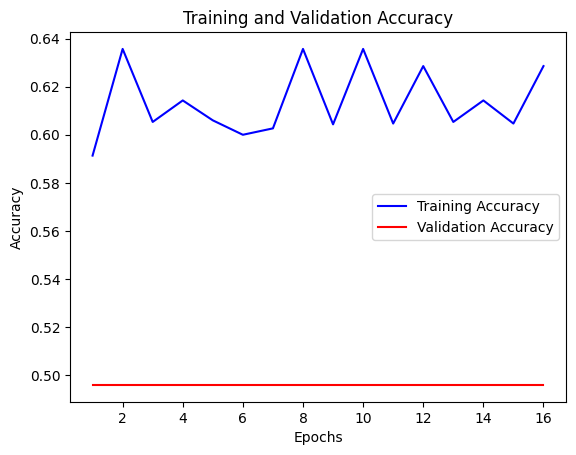

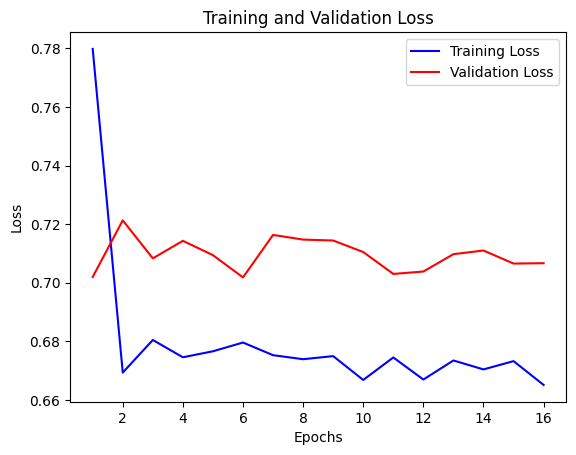

In [33]:
plot_training_history(history)

---------------------

**Model 2**

In [34]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [35]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

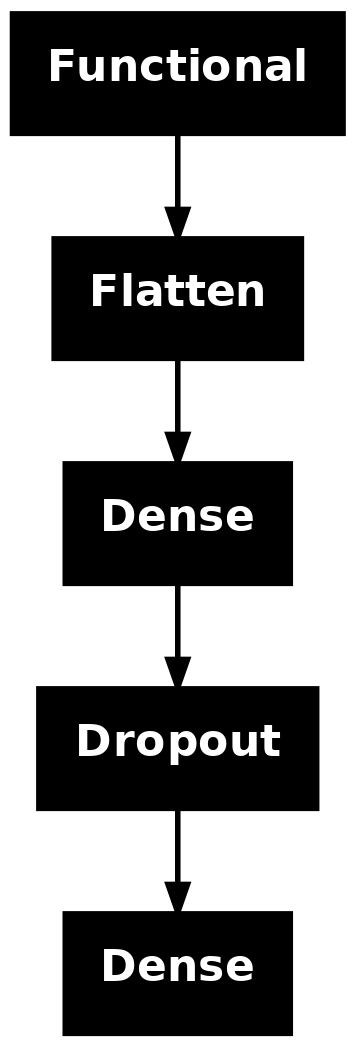

In [26]:
tf.keras.utils.plot_model(model_VGG16_2)

In [36]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-03 14:57:49.312809: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-03 14:57:49.711816: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.5679 - loss: 5.4360 - val_accuracy: 0.4959 - val_loss: 4.6482 - learning_rate: 1.0000e-05
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.6862 - loss: 4.4708

2024-12-03 14:58:31.466767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6517 - loss: 4.4927 - val_accuracy: 0.4959 - val_loss: 4.5789 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.5829 - loss: 4.2548 - val_accuracy: 0.4959 - val_loss: 3.6962 - learning_rate: 1.0000e-05
Epoch 4/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.4892 - loss: 3.6797

2024-12-03 14:59:11.631274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5685 - loss: 3.6023 - val_accuracy: 0.4959 - val_loss: 3.6215 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.5921 - loss: 3.3736 - val_accuracy: 0.4959 - val_loss: 2.9123 - learning_rate: 1.0000e-05
Epoch 6/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.6906 - loss: 2.7936

2024-12-03 14:59:51.947745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 14:59:51.947779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6376 - loss: 2.8178 - val_accuracy: 0.4959 - val_loss: 2.8915 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.5791 - loss: 2.7042 - val_accuracy: 0.4959 - val_loss: 2.3871 - learning_rate: 1.0000e-05
Epoch 8/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.5943 - loss: 2.3009

2024-12-03 15:00:32.261536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6067 - loss: 2.3011 - val_accuracy: 0.4959 - val_loss: 2.3740 - learning_rate: 1.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 233ms/step - accuracy: 0.5852 - loss: 2.1932 - val_accuracy: 0.4959 - val_loss: 1.9526 - learning_rate: 1.0000e-05
Epoch 10/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.7000 - loss: 1.8522

2024-12-03 15:01:12.748120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6516 - loss: 1.8761 - val_accuracy: 0.4959 - val_loss: 1.9603 - learning_rate: 1.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.5835 - loss: 1.8225 - val_accuracy: 0.4959 - val_loss: 1.6747 - learning_rate: 1.0000e-05
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - accuracy: 0.6033 - loss: 1.5744

2024-12-03 15:01:53.267764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6344 - loss: 1.5668 - val_accuracy: 0.4959 - val_loss: 1.6761 - learning_rate: 1.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.5814 - loss: 1.5353 - val_accuracy: 0.4959 - val_loss: 1.4200 - learning_rate: 1.0000e-05
Epoch 14/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - accuracy: 0.5886 - loss: 1.3849

2024-12-03 15:02:33.786717: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6064 - loss: 1.3533 - val_accuracy: 0.4959 - val_loss: 1.4098 - learning_rate: 1.0000e-05
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.5841 - loss: 1.3352 - val_accuracy: 0.4976 - val_loss: 1.2571 - learning_rate: 1.0000e-05
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6432 - loss: 1.1773 - val_accuracy: 0.4976 - val_loss: 1.2588 - learning_rate: 1.0000e-05
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.5872 - loss: 1.1833 - val_accuracy: 0.4959 - val_loss: 1.1551 - learning_rate: 1.0000e-05
Epoch 18/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.7240 - loss: 1.0564

2024-12-03 15:03:55.026571: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5826 - loss: 1.1097 - val_accuracy: 0.4959 - val_loss: 1.1588 - learning_rate: 1.0000e-05
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5932 - loss: 1.0738 - val_accuracy: 0.4959 - val_loss: 1.0647 - learning_rate: 1.0000e-05
Epoch 20/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - accuracy: 0.5931 - loss: 0.9786

2024-12-03 15:04:35.718572: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6203 - loss: 0.9765 - val_accuracy: 0.4959 - val_loss: 1.0814 - learning_rate: 1.0000e-05
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.5972 - loss: 0.9993 - val_accuracy: 0.4959 - val_loss: 1.0004 - learning_rate: 1.0000e-05
Epoch 22/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.6540 - loss: 0.9314

2024-12-03 15:05:16.358220: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6227 - loss: 0.9426 - val_accuracy: 0.4959 - val_loss: 1.0135 - learning_rate: 1.0000e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.5929 - loss: 0.9462 - val_accuracy: 0.5008 - val_loss: 0.9396 - learning_rate: 1.0000e-05
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.5865 - loss: 0.9111

2024-12-03 15:05:57.065145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6538 - loss: 0.8879 - val_accuracy: 0.4959 - val_loss: 0.9526 - learning_rate: 1.0000e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5877 - loss: 0.9083 - val_accuracy: 0.4959 - val_loss: 0.9356 - learning_rate: 1.0000e-05
Epoch 26/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.6219 - loss: 0.8548

2024-12-03 15:06:37.732037: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6560 - loss: 0.8566 - val_accuracy: 0.4959 - val_loss: 0.9363 - learning_rate: 1.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.5916 - loss: 0.8745 - val_accuracy: 0.4959 - val_loss: 0.9124 - learning_rate: 1.0000e-05
Epoch 28/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.6927 - loss: 0.7943

2024-12-03 15:07:18.380018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5818 - loss: 0.8712 - val_accuracy: 0.4959 - val_loss: 0.9362 - learning_rate: 1.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5912 - loss: 0.8549 - val_accuracy: 0.4959 - val_loss: 0.8951 - learning_rate: 1.0000e-05
Epoch 30/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.5846 - loss: 0.8303

2024-12-03 15:07:59.102274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 15:07:59.102303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6062 - loss: 0.8156 - val_accuracy: 0.4959 - val_loss: 0.9007 - learning_rate: 1.0000e-05
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5813 - loss: 0.8433 - val_accuracy: 0.4959 - val_loss: 0.8785 - learning_rate: 1.0000e-05
Epoch 32/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.5844 - loss: 0.8054

2024-12-03 15:08:39.781792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6416 - loss: 0.7927 - val_accuracy: 0.4959 - val_loss: 0.8883 - learning_rate: 1.0000e-05
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5968 - loss: 0.8256 - val_accuracy: 0.4959 - val_loss: 0.8703 - learning_rate: 1.0000e-05
Epoch 34/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.7002 - loss: 0.7574

2024-12-03 15:09:20.449078: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6310 - loss: 0.7933 - val_accuracy: 0.4959 - val_loss: 0.8783 - learning_rate: 1.0000e-05
Epoch 35/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5801 - loss: 0.8167 - val_accuracy: 0.4959 - val_loss: 0.8779 - learning_rate: 1.0000e-05
Epoch 36/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.5843 - loss: 0.8344

2024-12-03 15:10:01.164875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 15:10:01.164905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5788 - loss: 0.8255 - val_accuracy: 0.4959 - val_loss: 0.8649 - learning_rate: 1.0000e-05
Epoch 37/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.5928 - loss: 0.8079 - val_accuracy: 0.4959 - val_loss: 0.8410 - learning_rate: 1.0000e-05
Epoch 38/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.7406 - loss: 0.7228

2024-12-03 15:10:42.093467: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6739 - loss: 0.7563 - val_accuracy: 0.4959 - val_loss: 0.8529 - learning_rate: 1.0000e-05
Epoch 39/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5909 - loss: 0.7954 - val_accuracy: 0.4976 - val_loss: 0.8445 - learning_rate: 1.0000e-05
Epoch 40/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.7167 - loss: 0.7349

2024-12-03 15:11:22.841408: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6589 - loss: 0.7454 - val_accuracy: 0.4959 - val_loss: 0.8479 - learning_rate: 1.0000e-05


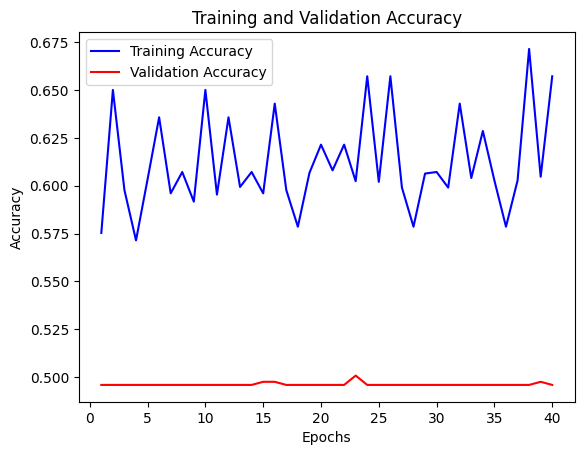

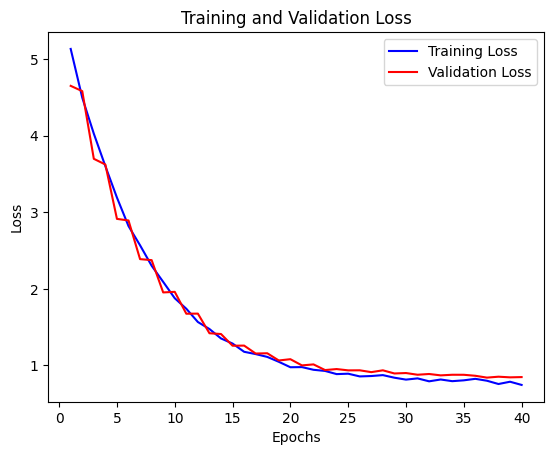

In [38]:
plot_training_history(history)

------------------------------

**Model 2.1**

In [39]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [40]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.5614 - loss: 5.4685 - val_accuracy: 0.4992 - val_loss: 4.6912 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5904 - loss: 4.5490 - val_accuracy: 0.4976 - val_loss: 4.5215 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.5576 - loss: 4.2484 - val_accuracy: 0.4943 - val_loss: 3.6709 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5598 - loss: 3.5577 - val_accuracy: 0.4976 - val_loss: 3.5374 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.5702 - loss: 3.3156 - val_accuracy: 0.4976 - val_loss: 2.9024 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5888 - loss: 2.8000 - val_accuracy: 0.4976 - val_loss: 2.8032 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 2

2024-12-03 15:17:26.265990: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6028 - loss: 1.7986 - val_accuracy: 0.4992 - val_loss: 1.8724 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5896 - loss: 1.7136 - val_accuracy: 0.4959 - val_loss: 1.5797 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6017 - loss: 1.4946 - val_accuracy: 0.4992 - val_loss: 1.5440 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5710 - loss: 1.4393 - val_accuracy: 0.5024 - val_loss: 1.3472 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5869 - loss: 1.2644 - val_accuracy: 0.5073 - val_loss: 1.3356 - learning_rate: 1.0000e-05
Epoch 15/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5924 - loss: 1.2287 - val_accuracy: 0.4992 - val_loss: 1.1995 - learning_rate: 1.0000e-05
Epoch 16/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/s

2024-12-03 15:19:28.144786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 15:19:28.144825: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6025 - loss: 1.1060 - val_accuracy: 0.4976 - val_loss: 1.1964 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5937 - loss: 1.0836 - val_accuracy: 0.4992 - val_loss: 1.0758 - learning_rate: 1.0000e-05
Epoch 18/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5672 - loss: 1.0101 - val_accuracy: 0.4992 - val_loss: 1.0615 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5900 - loss: 0.9759 - val_accuracy: 0.4976 - val_loss: 1.0014 - learning_rate: 1.0000e-05
Epoch 20/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.5748 - loss: 0.9180

2024-12-03 15:20:49.641794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5964 - loss: 0.9097 - val_accuracy: 0.4959 - val_loss: 0.9981 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.5970 - loss: 0.9047 - val_accuracy: 0.4976 - val_loss: 0.9545 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5833 - loss: 0.8514 - val_accuracy: 0.4976 - val_loss: 0.9461 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5855 - loss: 0.8673 - val_accuracy: 0.4992 - val_loss: 0.9155 - learning_rate: 1.0000e-05
Epoch 24/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.5608 - loss: 0.8404

2024-12-03 15:22:11.149749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5933 - loss: 0.8202 - val_accuracy: 0.5024 - val_loss: 0.9109 - learning_rate: 1.0000e-05
Epoch 25/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5894 - loss: 0.8253 - val_accuracy: 0.4992 - val_loss: 0.8984 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5741 - loss: 0.7996 - val_accuracy: 0.4959 - val_loss: 0.9082 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5843 - loss: 0.8018 - val_accuracy: 0.4959 - val_loss: 0.8711 - learning_rate: 1.0000e-05
Epoch 28/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6153 - loss: 0.7762 - val_accuracy: 0.4976 - val_loss: 0.8898 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.5832 - loss: 0.7917 - val_accuracy: 0.4976 - val_loss: 0.8569 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/ste

2024-12-03 15:25:34.739481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11366890401114318165
2024-12-03 15:25:34.739515: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 289166826894335813


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6055 - loss: 0.7527 - val_accuracy: 0.4959 - val_loss: 0.8590 - learning_rate: 1.0000e-05


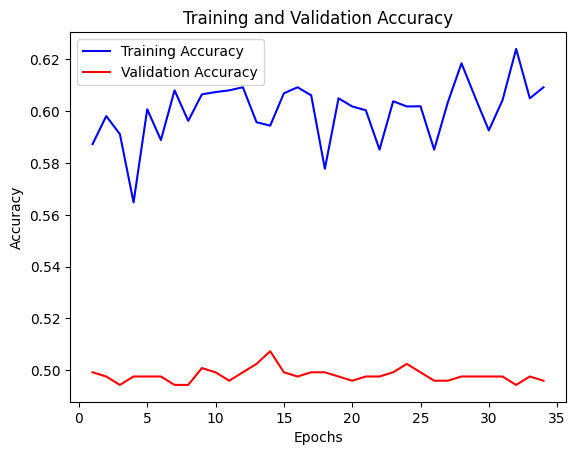

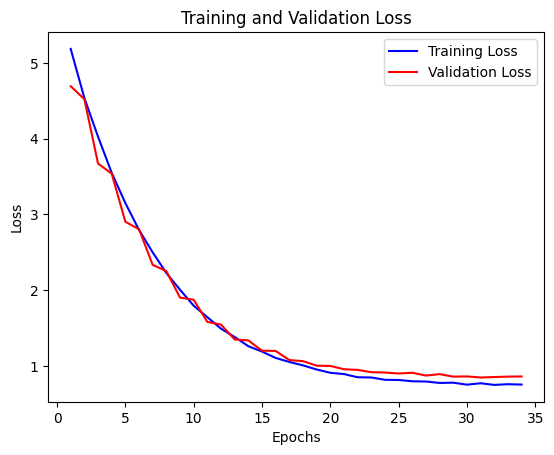

In [42]:
plot_training_history(history)

### *Transfer learning*

**Model 3**

In [46]:
#Extract features
train_features, train_labels = extract_features(train_ds, conv_base_VGG16)
val_features, val_labels = extract_features(val_ds, conv_base_VGG16)
test_features, test_labels = extract_features(test_ds, conv_base_VGG16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


AttributeError: '_ParallelMapDataset' object has no attribute 'batch_size'

In [9]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [15]:
#Training the Machine Learning Model

#Random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

Accuracy en validación: 0.6016260162601627
              precision    recall  f1-score   support

         0.0       0.83      0.26      0.40       310
         1.0       0.56      0.94      0.70       305

    accuracy                           0.60       615
   macro avg       0.69      0.60      0.55       615
weighted avg       0.69      0.60      0.55       615



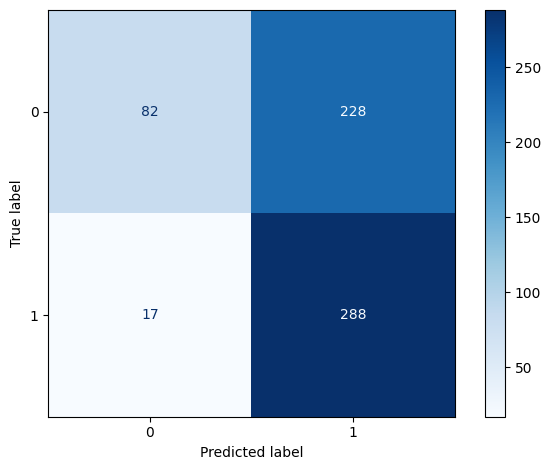

In [26]:
#Evaluating the model
val_predictions = random_forest.predict(val_features)
print("Accuracy en validación:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))

cm = confusion_matrix(val_labels, val_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

-----------------

### **Pretrained network ResNet-50**

In [5]:
#Load ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
resnet_base.trainable = False

resnet_base.summary()

I0000 00:00:1732262629.591397 4072329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

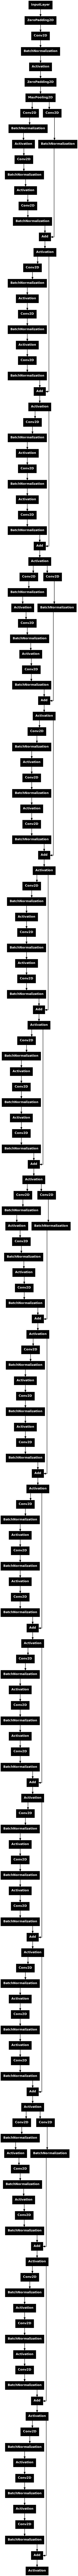

In [8]:
tf.keras.utils.plot_model(resnet_base)

### *Loading and preprocesing images*

In [15]:
#Loading and preprocessing images

#Creating a generator to preprocessing images using the class ImageDataGenerator
train_datagen = create_datagen(
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = create_datagen()

test_datagen = ImageDataGenerator()


train_generator = create_generator(train_datagen, train_dir, target_size = (224, 224), batch_size= 32)
train_labels = train_generator.classes
val_generator = create_generator(val_datagen, val_dir, target_size = (224, 224), batch_size= 32, shuffle = False)
val_labels = val_generator.classes
test_generator = create_generator(test_datagen, test_dir, target_size = (224, 224), batch_size= 32, shuffle = False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


### *Fine-tunning*

**Model 1**

In [10]:
model_resnet_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_1.add(resnet_base)

# Add personalized layers
model_resnet_1.add(layers.Flatten())  # Flatten extracted features
model_resnet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_1.add(layers.Dense(1, activation='sigmoid'))

model_resnet_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

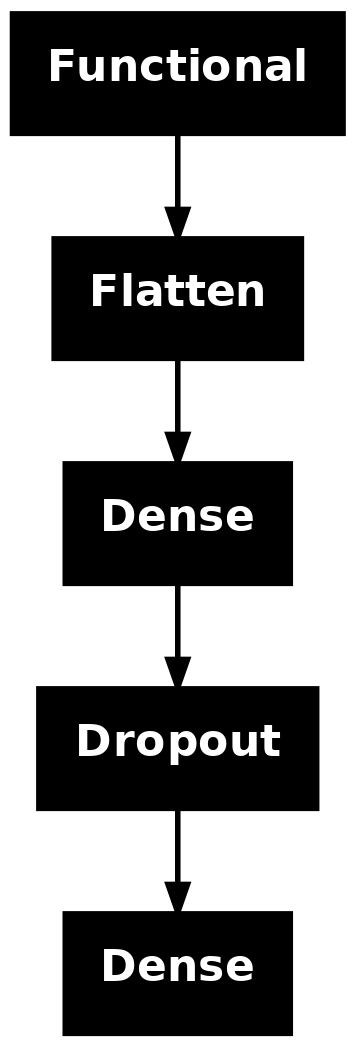

In [10]:
tf.keras.utils.plot_model(model_resnet_1)

In [11]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_resnet_1.fit(
    train_generator,
    steps_per_epoch = 130, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.5727 - loss: 3.5493

2024-11-22 10:03:41.385382: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-22 10:03:41.385464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.5737 - loss: 3.4913 - val_accuracy: 0.5593 - val_loss: 2.8359 - learning_rate: 1.0000e-05
Epoch 2/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.5789 - loss: 2.6452

2024-11-22 10:04:12.099435: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:04:12.099479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.5807 - loss: 2.6053 - val_accuracy: 0.4959 - val_loss: 2.1673 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5962 - loss: 1.9890 - val_accuracy: 0.4992 - val_loss: 1.7275 - learning_rate: 1.0000e-05
Epoch 4/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.5964 - loss: 1.5964

2024-11-22 10:05:05.041755: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:05:05.041782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.5985 - loss: 1.5768 - val_accuracy: 0.4992 - val_loss: 1.4117 - learning_rate: 1.0000e-05
Epoch 5/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.6137 - loss: 1.3024

2024-11-22 10:05:31.247411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6103 - loss: 1.2921 - val_accuracy: 0.4959 - val_loss: 1.2675 - learning_rate: 1.0000e-05
Epoch 6/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.5996 - loss: 1.1250

2024-11-22 10:05:58.119002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.5985 - loss: 1.1173 - val_accuracy: 0.4976 - val_loss: 1.0526 - learning_rate: 1.0000e-05
Epoch 7/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.5721 - loss: 1.0095

2024-11-22 10:06:24.799399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accuracy: 0.5774 - loss: 1.0029 - val_accuracy: 0.4959 - val_loss: 1.0696 - learning_rate: 1.0000e-05
Epoch 8/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.5950 - loss: 0.9234

2024-11-22 10:06:50.916402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:06:50.916435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5941 - loss: 0.9215 - val_accuracy: 0.4976 - val_loss: 0.9348 - learning_rate: 1.0000e-05
Epoch 9/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.6101 - loss: 0.8755

2024-11-22 10:07:18.078377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.6083 - loss: 0.8742 - val_accuracy: 0.4927 - val_loss: 0.8797 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5928 - loss: 0.8517 - val_accuracy: 0.4992 - val_loss: 0.8668 - learning_rate: 1.0000e-05
Epoch 11/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.5928 - loss: 0.8315

2024-11-22 10:08:10.709108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5952 - loss: 0.8301 - val_accuracy: 0.4992 - val_loss: 0.8827 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5884 - loss: 0.8220 - val_accuracy: 0.5008 - val_loss: 0.8379 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5885 - loss: 0.8068 - val_accuracy: 0.4992 - val_loss: 0.8628 - learning_rate: 1.0000e-05
Epoch 14/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.5952 - loss: 0.8008

2024-11-22 10:09:29.474826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5962 - loss: 0.8002 - val_accuracy: 0.4992 - val_loss: 0.8787 - learning_rate: 1.0000e-05
Epoch 15/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.6004 - loss: 0.7925

2024-11-22 10:09:55.677309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.6011 - loss: 0.7928 - val_accuracy: 0.4992 - val_loss: 0.8365 - learning_rate: 1.0000e-05
Epoch 16/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.6095 - loss: 0.7774

2024-11-22 10:10:21.870199: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6073 - loss: 0.7794 - val_accuracy: 0.4976 - val_loss: 0.8189 - learning_rate: 1.0000e-05
Epoch 17/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6230 - loss: 0.7780

2024-11-22 10:10:48.406286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.6199 - loss: 0.7793 - val_accuracy: 0.4992 - val_loss: 0.8432 - learning_rate: 1.0000e-05
Epoch 18/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.6014 - loss: 0.7849

2024-11-22 10:11:15.297400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.6025 - loss: 0.7838 - val_accuracy: 0.5008 - val_loss: 0.8264 - learning_rate: 1.0000e-05
Epoch 19/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.5945 - loss: 0.7850

2024-11-22 10:11:41.294231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5954 - loss: 0.7841 - val_accuracy: 0.5008 - val_loss: 0.8090 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6066 - loss: 0.7735 - val_accuracy: 0.4976 - val_loss: 0.8245 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6013 - loss: 0.7730 - val_accuracy: 0.4992 - val_loss: 0.8245 - learning_rate: 1.0000e-05
Epoch 22/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.5963 - loss: 0.7692

2024-11-22 10:12:59.839450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5992 - loss: 0.7680 - val_accuracy: 0.4992 - val_loss: 0.8158 - learning_rate: 1.0000e-05


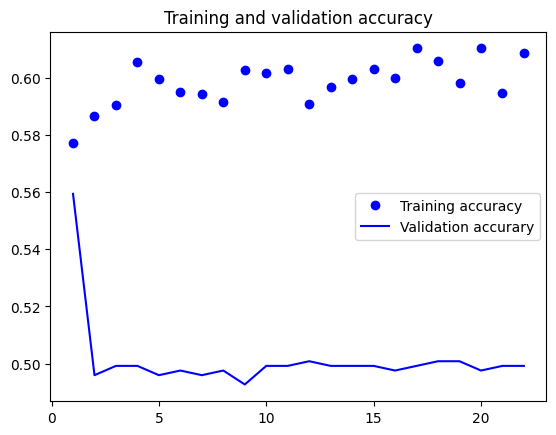

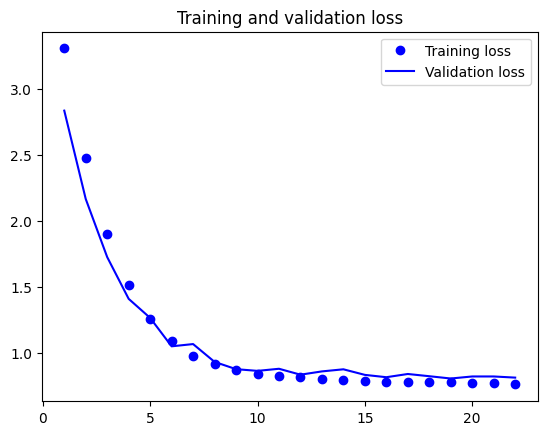

In [18]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

**Model 2**

In [6]:
model_resnet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_2.add(resnet_base)

# Add personalized layers
model_resnet_2.add(layers.GlobalAveragePooling2D())
model_resnet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_2.add(layers.Dense(1, activation='sigmoid'))

model_resnet_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

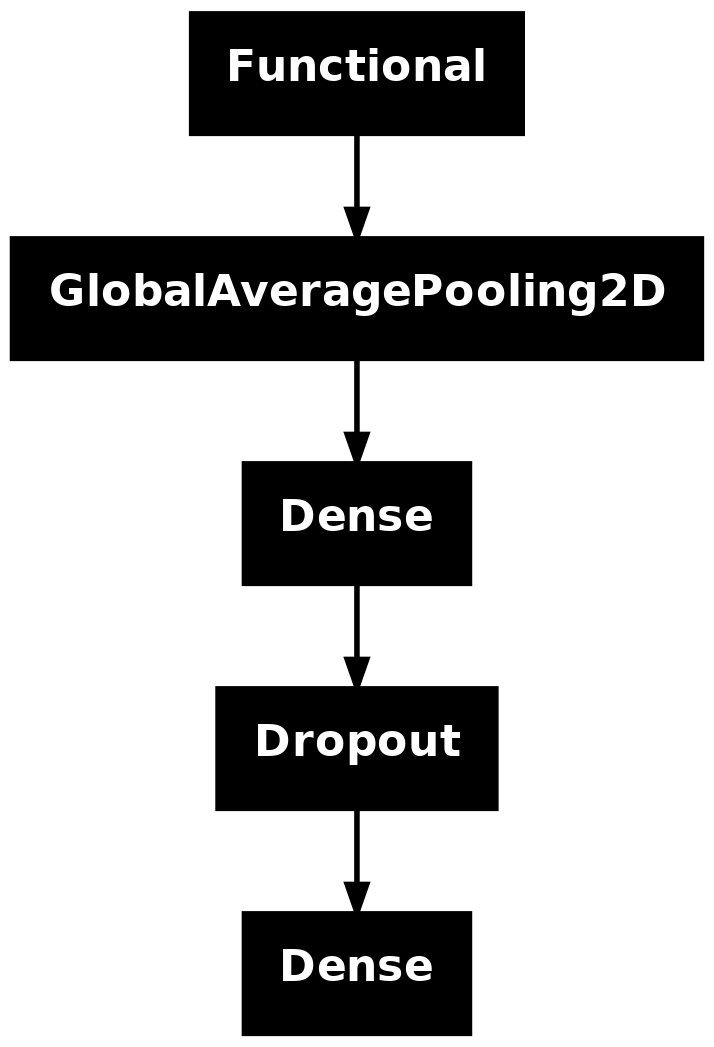

In [38]:
tf.keras.utils.plot_model(model_resnet_2)

In [7]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.2681744749596122), 1: np.float64(0.825446898002103)}


In [49]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_resnet_2.fit(
    train_generator,
    #steps_per_epoch = 130, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights  
)

Epoch 1/100


2024-11-21 15:21:15.781332: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.21568629, 0.21568629, 0.21568629],
         [0.21568629, 0.21568629, 0.21568629],
         [0.21443634, 0.21443634, 0.21443634],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.2141458 , 0.2141458 , 0.2141458 ],
         [0.21394606, 0.21394606, 0.21394606],
         [0.21321066, 0.21321066, 0.21321066],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.21568629, 0.21568629, 0.21568629],
         [0.21568629, 0.21568629, 0.21568629],
         [0.21443634, 0.21443634, 0.21443634],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.2141458 , 0.2141458 , 0.2141458 ],
         [0.21394606, 0.21394606, 0.21394606],
         [0.21321066, 0.21321066, 0.21321066],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        ...,

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]],

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]],

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.4940495 , 0.4940495 , 0.4940495 ],
         [0.51219785, 0.51219785, 0.51219785],
         [0.5246377 , 0.5246377 , 0.5246377 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.49394527, 0.49394527, 0.49394527],
         [0.5121144 , 0.5121144 , 0.5121144 ],
         [0.5246794 , 0.5246794 , 0.5246794 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.49384108, 0.49384108, 0.49384108],
         [0.5120311 , 0.5120311 , 0.5120311 ],
         [0.5247211 , 0.5247211 , 0.5247211 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        ...,

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04731702, 0.04731702, 0.04731702],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04733787, 0.04733787, 0.04733787],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04735871, 0.04735871, 0.04735871],
         ...,
         [0.10379671, 0.10379671, 0.10379671],
         [0.10381525, 0.10381525, 0.10381525],
         [0.10383379, 0.10383379, 0.10383379]]],


       ...,


       [[[0.19445938, 0.19445938, 0.19445938],
         [0.19432785, 0.19432785, 0.19432785],
         [0.1941963 , 0.1941963 , 0.1941963 ],
         ...,
         [0.19539481, 0.19539481, 0.19539481],
         [0.19544718, 0.19544718, 0.19544718],
         [0.18349212, 0.18349212, 0.18349212]],

        [[0.19091867, 0.19091867, 0.19091867],
         [0.19078712, 0.19078712, 0.19078712],
         [0.19065559, 0.19065559, 0.19065559],
         ...,
         [0.18759906, 0.18759906, 0.18759906],
         [0.19294576, 0.19294576, 0.19294576],
         [0.17855167, 0.17855167, 0.17855167]],

        [[0.18995   , 0.18995   , 0.18995   ],
         [0.19021307, 0.19021307, 0.19021307],
         [0.19047615, 0.19047615, 0.19047615],
         ...,
         [0.18692468, 0.18692468, 0.18692468],
         [0.19187087, 0.19187087, 0.19187087],
         [0.18002114, 0.18002114, 0.18002114]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0 [Op:__inference_one_step_on_iterator_361121]

    , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.  

2024-11-21 15:21:16.542551: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000

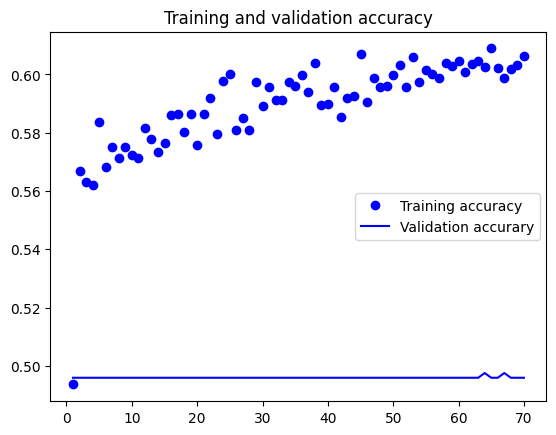

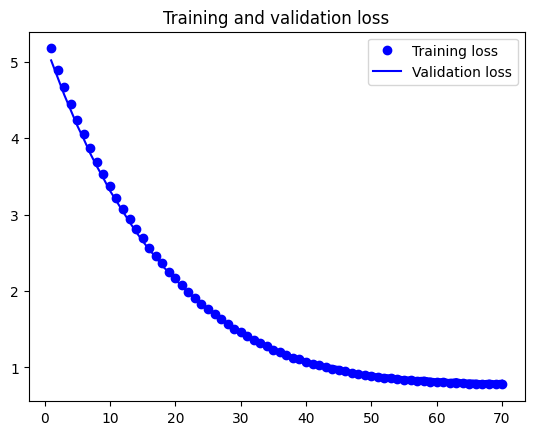

In [41]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

In [30]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
print("Primeras 10 etiquetas:", y_batch[:10])

x_batch shape: (20, 224, 224, 3), y_batch shape: (20,)
Primeras 10 etiquetas: [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]


#train_dir = "../1-Data/ml-dp/train"
loader = LoadImage(train_dir)

images_train = loader.images
names_train = loader.names

print(f"Number of images: {len(images_train)}") 
loader.plot_images_with_bboxes() 

loader = LoadImage(image_path='/ruta/a/imagenes', label_path='/ruta/a/labels')

#Train
preprocessor_train = PreprocessImage(images_train) 
resized_images_train, _ = preprocessor_train.resize_images_and_labels() #_ indicates that we don't have labels

resized_preprocessor_train = PreprocessImage(resized_images_train)
gray_images_train = resized_preprocessor_train.convert_to_grayscale()

normalized_preprocessor_train = PreprocessImage(gray_images_train)
normalized_images_train = normalized_preprocessor_train.normalize_images()

preprocessor = PreprocessImage(images, labels)
resized_images, labels = preprocessor.resize_images_and_labels()

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8738688811632515416
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5023793152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15785505328702574195
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


I0000 00:00:1731935039.155847  645814 gpu_device.cc:2022] Created device /device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [20]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
images, labels = next(train_generator)
print(type(labels))  # Debe ser numpy array
print(labels[:5])

<class 'numpy.ndarray'>
[1. 0. 0. 1. 1.]


### **CLAHE (Contrast Limited Adaptive Histogram Equalization)** para mejorar la calidad de las imágenes de rayos X